# SageMaker Processing own docker image

### Imports

Here we import the necessary libraries to interact with SageMaker.  We define our execution role, region, and the name of the S3 bucket in the account to which the tissue slide images will be downloaded.  We also create our SageMaker session.

In [16]:
import boto3
import sagemaker
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role
from sagemaker.session import s3_input

role = get_execution_role()
region = boto3.Session().region_name
bucket = '<bucket name>' # a bucket stored MNIST jpg files.
sagemaker_session = sagemaker.Session()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [14]:
import os
import matplotlib.pyplot as plt

### MNIST files

Find MNIST jpg files provider. like below.

https://github.com/teavanist/MNIST-JPG/blob/master/MNIST%20Dataset%20JPG%20format.zip

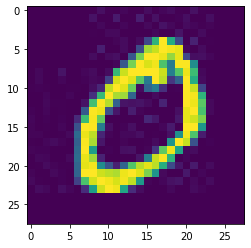

In [45]:
# Download sample a MNIST file sample from S3
s3 = boto3.resource('s3', region_name=region)

# actural file
## s3://<bucket name>/mnist/train/0/1.jpg

image_file = '1.jpg'
key = f'mnist/train/0/{image_file}'

s3.Bucket(bucket).download_file(key, f'./images/{image_file}')

%matplotlib inline
import matplotlib.image as mpimg

img = mpimg.imread(f'./images/{image_file}')
imgplot = plt.imshow(img)

## Build Docker container for preprocessing SVS files into TFRecords

### Dockerfile

Visualize the Docker file that defines the container to be used by SageMaker Processing.

In [46]:
!pygmentize Dockerfile

FROM ubuntu:20.04

ENV DEBIAN_FRONTEND=noninteractive

RUN apt update -y && apt upgrade -y

RUN apt install -y python3
RUN apt install -y python3-pip --fix-missing

RUN pip3 install scikit-build
RUN pip3 install opencv-python
RUN pip3 install numpy
RUN apt install -y libopencv-dev

WORKDIR /home
COPY src/script-mnist.py .

# Make sure python doesn't buffer stdout so we get logs ASAP.
ENV PYTHONUNBUFFERED=TRUE

ENTRYPOINT ["python3", "script-mnist.py"]


### Python script for preprocessing

Visualize the python script that orchestrates the preprocessing of the images within the Docker container.

In [47]:
!pygmentize src/script-mnist.py

import subprocess
import os
import pathlib
import argparse
import shutil
import random
import uuid

from glob import glob

import numpy as np
import cv2

def blur(n_kernel, input_path, output_path):
    files = glob(f'{input_path}/**/*.jpg', recursive=True)
    
    for file in files:
        img = cv2.imread(file)
        kernel = np.ones((n_kernel,n_kernel),np.float32)/25
        dst = cv2.filter2D(img,-1,kernel)
        
        file_name = os.path.basename(file)
        dir_name = os.path.dirname(file)
        parent_dir_name = os.path.basename(dir_name)

        print(f'{output_path}/{parent_dir_name}/{file_name}')

        if not os.path.exists(f'{output_path}/{parent_dir_name}'):
            os.makedirs(f'{output_path}/{parent_dir_name}')
        
        cv2.imwrite(f'{output_path}/{parent_dir_name}/{file_name}', dst)
    print('number of processing files: %i' % len(files))
    
    
def main(n_kernel):
    input_path = '/opt/ml/processing/input' #fixed input path
    output_pa

### Build container and upload it to ECR

Build and push the Docker image to Amazon's Elastic Container Registry (ECR) so that it can be used by SageMaker Processing.

In [48]:
from docker_utils import build_and_push_docker_image

repository_short_name = 'mnist-processing-b'
image_name = build_and_push_docker_image(repository_short_name)

Building docker image mnist-processing-b from Dockerfile
$ docker build -t mnist-processing-b -f Dockerfile .
Sending build context to Docker daemon  17.45MB
Step 1/13 : FROM ubuntu:20.04
 ---> ba6acccedd29
Step 2/13 : ENV DEBIAN_FRONTEND=noninteractive
 ---> Using cache
 ---> f619e8104ca0
Step 3/13 : RUN apt update -y && apt upgrade -y
 ---> Using cache
 ---> 180cfa4c1a1b
Step 4/13 : RUN apt install -y python3
 ---> Using cache
 ---> 69f9c3edae22
Step 5/13 : RUN apt install -y python3-pip --fix-missing
 ---> Using cache
 ---> 19e6765d1812
Step 6/13 : RUN pip3 install scikit-build
 ---> Using cache
 ---> 55a2c2a326d1
Step 7/13 : RUN pip3 install opencv-python
 ---> Using cache
 ---> 61425532294e
Step 8/13 : RUN pip3 install numpy
 ---> Using cache
 ---> a6a34ff4c8ea
Step 9/13 : RUN apt install -y libopencv-dev
 ---> Using cache
 ---> 9b9e3ff08ef1
Step 10/13 : WORKDIR /home
 ---> Using cache
 ---> 1cb10ca0efc0
Step 11/13 : COPY src/script-mnist.py .
 ---> Using cache
 ---> 1e31d1020449


## Launch SageMaker Processing Job


Now we are ready to launch the SageMaker Processing job on our images.  The SVS slide images are pre-processed in three steps.

* *Tiling images*: The images are tiled by non-overlapping 512×512-pixel windows, and tiles containing over 50% background are discarded. The tiles are stored as JPEG images.
* *Converting images to TFRecords*: We use SageMaker Pipe Mode to reduce our training time, which requires the data to be available in a proto-buffer format. TFRecord is a popular proto-buffer format used for training models with TensorFlow. SageMaker Pipe Mode and proto-buffer format are explained in detail in the following section
* *Sorting TFRecords :* We sort the dataset into test, train and validation cohorts for a 3-way classifier (LUAD/LUSC/Normal). In the TCGA dataset, there can be multiple slide images corresponding to a single patient. We need to make sure all the tiles generated from slides corresponding to the same patient should occupy the same split to avoid data leakage.  For the test set, we create per-slide TFRecords containing all of the tiles from that slide so that we may evaluate the model in the way it will eventually be realistically deployed.

In [44]:
processor = Processor(image_uri=image_name,
                      role=get_execution_role(),
                      instance_count=10,               # run the job on 16 instances
                      base_job_name='mnist-gaussian', # should be unique name
                      instance_type='ml.m5.4xlarge', 
                      volume_size_in_gb=200)

processor.run(inputs=[ProcessingInput(
    source=f's3://{bucket}/mnist/train', # s3 input prefix
    s3_data_type='S3Prefix',
    s3_input_mode='File',
    s3_data_distribution_type='ShardedByS3Key', # Split the data across instances
    destination='/opt/ml/processing/input')], # local path on the container
    outputs=[ProcessingOutput(
        source='/opt/ml/processing/output', # local output path on the container
        destination=f's3://{bucket}/mnist/output/' # output s3 location
    )],
    arguments=['5'], # kernel of gaussian
    wait=True,
    logs=True)


Job Name:  mnist-gaussian-2021-12-12-03-54-39-663
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://aws-ml-data-tokyo/mnist/train', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'ShardedByS3Key', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'output-1', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://aws-ml-data-tokyo/mnist/output/', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
............................../opt/ml/processing/output/7/17373.jpg
/opt/ml/processing/output/7/13802.jpg
/opt/ml/processing/output/7/4858.jpg
/opt/ml/processing/output/7/56086.jpg
/opt/ml/processing/output/7/34079.jpg
/opt/ml/processing/output/7/34689.jpg
/opt/ml/processing/output/7/21937.jpg
/opt/ml/processing/output/7/26395.jpg
/opt/ml/processing/output/7/11332.jpg
/opt/ml/processing/output/7/50972.jpg
/opt/ml/processing/output/7/34825.jpg
/opt/ml/processing/output/7/3

/opt/ml/processing/output/1/871.jpg
/opt/ml/processing/output/1/50465.jpg
/opt/ml/processing/output/1/31829.jpg
/opt/ml/processing/output/1/17839.jpg
/opt/ml/processing/output/1/35116.jpg
/opt/ml/processing/output/1/6043.jpg
/opt/ml/processing/output/1/3963.jpg
/opt/ml/processing/output/1/26473.jpg
/opt/ml/processing/output/1/38464.jpg
/opt/ml/processing/output/1/38847.jpg
/opt/ml/processing/output/1/35945.jpg
/opt/ml/processing/output/1/33658.jpg
/opt/ml/processing/output/1/50094.jpg
/opt/ml/processing/output/1/7410.jpg
/opt/ml/processing/output/1/42268.jpg
/opt/ml/processing/output/1/42102.jpg
/opt/ml/processing/output/1/11312.jpg
/opt/ml/processing/output/1/31323.jpg
/opt/ml/processing/output/1/47527.jpg
/opt/ml/processing/output/1/33398.jpg
/opt/ml/processing/output/1/17750.jpg
/opt/ml/processing/output/1/37023.jpg
/opt/ml/processing/output/1/23532.jpg
/opt/ml/processing/output/1/12793.jpg
/opt/ml/processing/output/1/44682.jpg
/opt/ml/processing/output/1/56278.jpg
/opt/ml/processin

/opt/ml/processing/output/8/16036.jpg
/opt/ml/processing/output/8/50306.jpg
/opt/ml/processing/output/8/41931.jpg
/opt/ml/processing/output/8/50634.jpg
/opt/ml/processing/output/8/31760.jpg
/opt/ml/processing/output/8/46519.jpg
/opt/ml/processing/output/8/46080.jpg
/opt/ml/processing/output/8/3807.jpg
/opt/ml/processing/output/8/19371.jpg
/opt/ml/processing/output/8/46633.jpg
/opt/ml/processing/output/8/9661.jpg
/opt/ml/processing/output/8/6744.jpg
/opt/ml/processing/output/8/23263.jpg
/opt/ml/processing/output/8/2991.jpg
/opt/ml/processing/output/8/33719.jpg
/opt/ml/processing/output/8/17358.jpg
/opt/ml/processing/output/8/21863.jpg
/opt/ml/processing/output/8/3872.jpg
/opt/ml/processing/output/8/58666.jpg
/opt/ml/processing/output/8/16994.jpg
/opt/ml/processing/output/8/22001.jpg
/opt/ml/processing/output/8/49016.jpg
/opt/ml/processing/output/8/40306.jpg
/opt/ml/processing/output/8/11734.jpg
/opt/ml/processing/output/8/13869.jpg
/opt/ml/processing/output/8/40031.jpg
/opt/ml/processin

/opt/ml/processing/output/4/52417.jpg
/opt/ml/processing/output/4/4417.jpg
/opt/ml/processing/output/4/14652.jpg
/opt/ml/processing/output/4/59722.jpg
/opt/ml/processing/output/4/20059.jpg
/opt/ml/processing/output/4/22085.jpg
/opt/ml/processing/output/4/27473.jpg
/opt/ml/processing/output/4/18487.jpg
/opt/ml/processing/output/4/44523.jpg
/opt/ml/processing/output/4/28043.jpg
/opt/ml/processing/output/4/8325.jpg
/opt/ml/processing/output/4/41838.jpg
/opt/ml/processing/output/4/22012.jpg
/opt/ml/processing/output/4/55037.jpg
/opt/ml/processing/output/4/27129.jpg
/opt/ml/processing/output/4/51454.jpg
/opt/ml/processing/output/4/47198.jpg
/opt/ml/processing/output/4/31412.jpg
/opt/ml/processing/output/4/51817.jpg
/opt/ml/processing/output/4/35818.jpg
/opt/ml/processing/output/4/35989.jpg
/opt/ml/processing/output/4/39486.jpg
/opt/ml/processing/output/4/56802.jpg
/opt/ml/processing/output/4/25887.jpg
/opt/ml/processing/output/4/30016.jpg
/opt/ml/processing/output/4/1379.jpg
/opt/ml/process

/opt/ml/processing/output/3/56457.jpg
/opt/ml/processing/output/3/53609.jpg
/opt/ml/processing/output/3/52240.jpg
/opt/ml/processing/output/3/35582.jpg
/opt/ml/processing/output/3/45480.jpg
/opt/ml/processing/output/3/43816.jpg
/opt/ml/processing/output/3/11075.jpg
/opt/ml/processing/output/3/26503.jpg
/opt/ml/processing/output/3/7590.jpg
/opt/ml/processing/output/3/16849.jpg
/opt/ml/processing/output/3/54615.jpg
/opt/ml/processing/output/3/47628.jpg
/opt/ml/processing/output/3/57426.jpg
/opt/ml/processing/output/3/36082.jpg
/opt/ml/processing/output/3/44.jpg
/opt/ml/processing/output/3/27946.jpg
/opt/ml/processing/output/3/6298.jpg
/opt/ml/processing/output/3/6040.jpg
/opt/ml/processing/output/3/22251.jpg
/opt/ml/processing/output/3/3323.jpg
/opt/ml/processing/output/3/28527.jpg
/opt/ml/processing/output/3/44510.jpg
/opt/ml/processing/output/3/11544.jpg
/opt/ml/processing/output/3/40307.jpg
/opt/ml/processing/output/3/56528.jpg
/opt/ml/processing/output/3/34259.jpg
/opt/ml/processing/

/opt/ml/processing/output/3/12968.jpg
/opt/ml/processing/output/3/57952.jpg
/opt/ml/processing/output/3/1476.jpg
/opt/ml/processing/output/3/30907.jpg
/opt/ml/processing/output/3/55474.jpg
/opt/ml/processing/output/3/19865.jpg
/opt/ml/processing/output/3/51675.jpg
/opt/ml/processing/output/3/46702.jpg
/opt/ml/processing/output/3/10677.jpg
/opt/ml/processing/output/3/24414.jpg
/opt/ml/processing/output/3/38998.jpg
/opt/ml/processing/output/3/13740.jpg
/opt/ml/processing/output/3/5323.jpg
/opt/ml/processing/output/3/2114.jpg
/opt/ml/processing/output/3/36227.jpg
/opt/ml/processing/output/3/9412.jpg
/opt/ml/processing/output/3/22863.jpg
/opt/ml/processing/output/3/36130.jpg
/opt/ml/processing/output/3/48431.jpg
/opt/ml/processing/output/3/26644.jpg
/opt/ml/processing/output/3/49297.jpg
/opt/ml/processing/output/3/6016.jpg
/opt/ml/processing/output/3/29608.jpg
/opt/ml/processing/output/3/42505.jpg
/opt/ml/processing/output/3/52590.jpg
/opt/ml/processing/output/3/27840.jpg
/opt/ml/processin

/opt/ml/processing/output/7/25985.jpg
/opt/ml/processing/output/7/56567.jpg
/opt/ml/processing/output/7/21482.jpg
/opt/ml/processing/output/7/58078.jpg
/opt/ml/processing/output/7/13482.jpg
/opt/ml/processing/output/7/1057.jpg
/opt/ml/processing/output/7/4840.jpg
/opt/ml/processing/output/7/48208.jpg
/opt/ml/processing/output/7/3282.jpg
/opt/ml/processing/output/7/57119.jpg
/opt/ml/processing/output/7/6600.jpg
/opt/ml/processing/output/7/9499.jpg
/opt/ml/processing/output/7/11130.jpg
/opt/ml/processing/output/7/33627.jpg
/opt/ml/processing/output/7/25830.jpg
/opt/ml/processing/output/7/23442.jpg
/opt/ml/processing/output/7/54542.jpg
/opt/ml/processing/output/7/40505.jpg
/opt/ml/processing/output/7/47495.jpg
/opt/ml/processing/output/7/19473.jpg
/opt/ml/processing/output/7/48861.jpg
/opt/ml/processing/output/7/43089.jpg
/opt/ml/processing/output/7/48125.jpg
/opt/ml/processing/output/7/20229.jpg
/opt/ml/processing/output/7/58282.jpg
/opt/ml/processing/output/7/44566.jpg
/opt/ml/processin

/opt/ml/processing/output/4/59026.jpg
/opt/ml/processing/output/4/2334.jpg
/opt/ml/processing/output/4/4433.jpg
/opt/ml/processing/output/4/22531.jpg
/opt/ml/processing/output/4/55385.jpg
/opt/ml/processing/output/4/20455.jpg
/opt/ml/processing/output/4/30186.jpg
/opt/ml/processing/output/4/8560.jpg
/opt/ml/processing/output/4/14296.jpg
/opt/ml/processing/output/4/58319.jpg
/opt/ml/processing/output/4/57146.jpg
/opt/ml/processing/output/4/51449.jpg
/opt/ml/processing/output/4/44515.jpg
/opt/ml/processing/output/4/14637.jpg
/opt/ml/processing/output/4/56705.jpg
/opt/ml/processing/output/4/48635.jpg
/opt/ml/processing/output/4/2071.jpg
/opt/ml/processing/output/4/44587.jpg
/opt/ml/processing/output/4/48786.jpg
/opt/ml/processing/output/4/34808.jpg
/opt/ml/processing/output/4/5324.jpg
/opt/ml/processing/output/4/17523.jpg
/opt/ml/processing/output/4/53144.jpg
/opt/ml/processing/output/4/38717.jpg
/opt/ml/processing/output/1/48368.jpg
/opt/ml/processing/output/1/8725.jpg
/opt/ml/processing

/opt/ml/processing/output/0/55582.jpg
/opt/ml/processing/output/0/51573.jpg
/opt/ml/processing/output/0/26930.jpg
/opt/ml/processing/output/0/57176.jpg
/opt/ml/processing/output/0/30484.jpg
/opt/ml/processing/output/0/52625.jpg
/opt/ml/processing/output/0/47815.jpg
/opt/ml/processing/output/0/48421.jpg
/opt/ml/processing/output/0/25199.jpg
/opt/ml/processing/output/0/56419.jpg
/opt/ml/processing/output/0/26713.jpg
/opt/ml/processing/output/0/47914.jpg
/opt/ml/processing/output/0/40075.jpg
/opt/ml/processing/output/0/47389.jpg
/opt/ml/processing/output/0/29621.jpg
/opt/ml/processing/output/0/20463.jpg
/opt/ml/processing/output/0/29039.jpg
/opt/ml/processing/output/0/6341.jpg
/opt/ml/processing/output/0/10334.jpg
/opt/ml/processing/output/0/30119.jpg
/opt/ml/processing/output/0/45307.jpg
/opt/ml/processing/output/0/56236.jpg
/opt/ml/processing/output/0/17025.jpg
/opt/ml/processing/output/0/43811.jpg
/opt/ml/processing/output/0/31808.jpg
/opt/ml/processing/output/0/50974.jpg
/opt/ml/proce

/opt/ml/processing/output/6/36363.jpg
/opt/ml/processing/output/6/52833.jpg
/opt/ml/processing/output/6/56098.jpg
/opt/ml/processing/output/6/43589.jpg
/opt/ml/processing/output/6/4497.jpg
/opt/ml/processing/output/6/50818.jpg
/opt/ml/processing/output/6/51514.jpg
/opt/ml/processing/output/6/49083.jpg
/opt/ml/processing/output/6/51745.jpg
/opt/ml/processing/output/6/40907.jpg
/opt/ml/processing/output/6/35948.jpg
/opt/ml/processing/output/6/39440.jpg
/opt/ml/processing/output/6/51096.jpg
/opt/ml/processing/output/6/51402.jpg
/opt/ml/processing/output/6/5524.jpg
/opt/ml/processing/output/6/18575.jpg
/opt/ml/processing/output/6/44017.jpg
/opt/ml/processing/output/6/16534.jpg
/opt/ml/processing/output/6/43646.jpg
/opt/ml/processing/output/6/35169.jpg
/opt/ml/processing/output/6/54425.jpg
/opt/ml/processing/output/6/26563.jpg
/opt/ml/processing/output/6/54227.jpg
/opt/ml/processing/output/6/24079.jpg
/opt/ml/processing/output/6/9816.jpg
/opt/ml/processing/output/6/15401.jpg
/opt/ml/process

/opt/ml/processing/output/8/47154.jpg
/opt/ml/processing/output/8/2685.jpg
/opt/ml/processing/output/8/13122.jpg
/opt/ml/processing/output/8/56881.jpg
/opt/ml/processing/output/8/7328.jpg
/opt/ml/processing/output/8/42878.jpg
/opt/ml/processing/output/8/44427.jpg
/opt/ml/processing/output/8/51134.jpg
/opt/ml/processing/output/1/44650.jpg
/opt/ml/processing/output/1/22410.jpg
/opt/ml/processing/output/1/46113.jpg
/opt/ml/processing/output/1/50572.jpg
/opt/ml/processing/output/1/41019.jpg
/opt/ml/processing/output/1/17986.jpg
/opt/ml/processing/output/1/17782.jpg
/opt/ml/processing/output/1/22135.jpg
/opt/ml/processing/output/1/44887.jpg
/opt/ml/processing/output/1/52046.jpg
/opt/ml/processing/output/1/7429.jpg
/opt/ml/processing/output/1/30639.jpg
/opt/ml/processing/output/1/38526.jpg
/opt/ml/processing/output/1/42531.jpg
/opt/ml/processing/output/1/31237.jpg
/opt/ml/processing/output/1/52531.jpg
/opt/ml/processing/output/1/3602.jpg
/opt/ml/processing/output/1/42307.jpg
/opt/ml/processi

/opt/ml/processing/output/9/29980.jpg
/opt/ml/processing/output/9/27116.jpg
/opt/ml/processing/output/9/3169.jpg
/opt/ml/processing/output/9/3076.jpg
/opt/ml/processing/output/9/53342.jpg
/opt/ml/processing/output/9/43253.jpg
/opt/ml/processing/output/9/48077.jpg
/opt/ml/processing/output/9/37906.jpg
/opt/ml/processing/output/9/16020.jpg
/opt/ml/processing/output/9/13361.jpg
/opt/ml/processing/output/9/57563.jpg
/opt/ml/processing/output/9/36945.jpg
/opt/ml/processing/output/9/45086.jpg
/opt/ml/processing/output/9/56062.jpg
/opt/ml/processing/output/9/55125.jpg
/opt/ml/processing/output/9/52355.jpg
/opt/ml/processing/output/9/28618.jpg
/opt/ml/processing/output/9/52553.jpg
/opt/ml/processing/output/9/22230.jpg
/opt/ml/processing/output/9/41924.jpg
/opt/ml/processing/output/9/8111.jpg
/opt/ml/processing/output/9/13032.jpg
/opt/ml/processing/output/9/46497.jpg
/opt/ml/processing/output/9/29113.jpg
/opt/ml/processing/output/9/31767.jpg
/opt/ml/processing/output/9/57895.jpg
/opt/ml/process

/opt/ml/processing/output/8/29629.jpg
/opt/ml/processing/output/8/16275.jpg
/opt/ml/processing/output/8/44433.jpg
/opt/ml/processing/output/8/14478.jpg
/opt/ml/processing/output/8/55445.jpg
/opt/ml/processing/output/8/8732.jpg
/opt/ml/processing/output/8/59565.jpg
/opt/ml/processing/output/8/6620.jpg
/opt/ml/processing/output/8/6353.jpg
/opt/ml/processing/output/8/34696.jpg
/opt/ml/processing/output/8/36959.jpg
/opt/ml/processing/output/8/11568.jpg
/opt/ml/processing/output/8/25731.jpg
/opt/ml/processing/output/8/46099.jpg
/opt/ml/processing/output/8/3002.jpg
/opt/ml/processing/output/8/53569.jpg
/opt/ml/processing/output/8/22813.jpg
/opt/ml/processing/output/8/31706.jpg
/opt/ml/processing/output/8/54821.jpg
/opt/ml/processing/output/8/57741.jpg
/opt/ml/processing/output/8/31770.jpg
/opt/ml/processing/output/8/30803.jpg
/opt/ml/processing/output/8/26294.jpg
/opt/ml/processing/output/8/9241.jpg
/opt/ml/processing/output/8/42540.jpg
/opt/ml/processing/output/8/39266.jpg
/opt/ml/processin

/opt/ml/processing/output/2/35014.jpg
/opt/ml/processing/output/2/20078.jpg
/opt/ml/processing/output/2/15853.jpg
/opt/ml/processing/output/2/199.jpg
/opt/ml/processing/output/2/54553.jpg
/opt/ml/processing/output/2/49247.jpg
/opt/ml/processing/output/1/27309.jpg
/opt/ml/processing/output/1/31280.jpg
/opt/ml/processing/output/1/58767.jpg
/opt/ml/processing/output/1/28019.jpg
/opt/ml/processing/output/1/40879.jpg
/opt/ml/processing/output/1/838.jpg
/opt/ml/processing/output/1/53833.jpg
/opt/ml/processing/output/1/23886.jpg
/opt/ml/processing/output/1/19897.jpg
/opt/ml/processing/output/1/29040.jpg
/opt/ml/processing/output/1/36071.jpg
/opt/ml/processing/output/1/35749.jpg
/opt/ml/processing/output/1/21088.jpg
/opt/ml/processing/output/1/4685.jpg
/opt/ml/processing/output/1/19400.jpg
/opt/ml/processing/output/1/47327.jpg
/opt/ml/processing/output/1/30457.jpg
/opt/ml/processing/output/1/8513.jpg
/opt/ml/processing/output/1/48943.jpg
/opt/ml/processing/output/1/27707.jpg
/opt/ml/processing

/opt/ml/processing/output/6/8523.jpg
/opt/ml/processing/output/6/22422.jpg
/opt/ml/processing/output/6/5654.jpg
/opt/ml/processing/output/6/21234.jpg
/opt/ml/processing/output/6/49043.jpg
/opt/ml/processing/output/6/21298.jpg
/opt/ml/processing/output/6/37421.jpg
/opt/ml/processing/output/6/13084.jpg
/opt/ml/processing/output/6/28150.jpg
/opt/ml/processing/output/6/5413.jpg
/opt/ml/processing/output/6/2479.jpg
/opt/ml/processing/output/6/155.jpg
/opt/ml/processing/output/6/12673.jpg
/opt/ml/processing/output/6/44237.jpg
/opt/ml/processing/output/6/52768.jpg
/opt/ml/processing/output/6/19530.jpg
/opt/ml/processing/output/6/18678.jpg
/opt/ml/processing/output/6/48565.jpg
/opt/ml/processing/output/6/19002.jpg
/opt/ml/processing/output/6/45368.jpg
/opt/ml/processing/output/6/51965.jpg
/opt/ml/processing/output/6/34686.jpg
/opt/ml/processing/output/6/4431.jpg
/opt/ml/processing/output/6/36305.jpg
/opt/ml/processing/output/6/299.jpg
/opt/ml/processing/output/6/39475.jpg
/opt/ml/processing/ou

/opt/ml/processing/output/2/58512.jpg
/opt/ml/processing/output/2/42188.jpg
/opt/ml/processing/output/2/51419.jpg
/opt/ml/processing/output/2/30094.jpg
/opt/ml/processing/output/2/52975.jpg
/opt/ml/processing/output/2/5509.jpg
/opt/ml/processing/output/2/7792.jpg
/opt/ml/processing/output/2/8078.jpg
/opt/ml/processing/output/2/36463.jpg
/opt/ml/processing/output/2/52755.jpg
/opt/ml/processing/output/2/18622.jpg
/opt/ml/processing/output/2/22990.jpg
/opt/ml/processing/output/2/13613.jpg
/opt/ml/processing/output/2/10657.jpg
/opt/ml/processing/output/2/55228.jpg
/opt/ml/processing/output/2/59061.jpg
/opt/ml/processing/output/2/58241.jpg
/opt/ml/processing/output/2/56579.jpg
/opt/ml/processing/output/2/37291.jpg
/opt/ml/processing/output/2/25510.jpg
/opt/ml/processing/output/2/6649.jpg
/opt/ml/processing/output/2/51931.jpg
/opt/ml/processing/output/2/6391.jpg
/opt/ml/processing/output/2/56282.jpg
/opt/ml/processing/output/2/44090.jpg
/opt/ml/processing/output/2/25994.jpg
/opt/ml/processin

/opt/ml/processing/output/6/59417.jpg
/opt/ml/processing/output/6/56582.jpg
/opt/ml/processing/output/6/52534.jpg
/opt/ml/processing/output/6/46715.jpg
/opt/ml/processing/output/6/14129.jpg
/opt/ml/processing/output/6/14453.jpg
/opt/ml/processing/output/6/47376.jpg
/opt/ml/processing/output/6/10671.jpg
/opt/ml/processing/output/6/51220.jpg
/opt/ml/processing/output/6/47450.jpg
/opt/ml/processing/output/6/26977.jpg
/opt/ml/processing/output/6/11390.jpg
/opt/ml/processing/output/6/17273.jpg
/opt/ml/processing/output/6/21290.jpg
/opt/ml/processing/output/6/31000.jpg
/opt/ml/processing/output/6/8497.jpg
/opt/ml/processing/output/6/36125.jpg
/opt/ml/processing/output/6/27708.jpg
/opt/ml/processing/output/6/44879.jpg
/opt/ml/processing/output/6/43720.jpg
/opt/ml/processing/output/9/32916.jpg
/opt/ml/processing/output/9/46866.jpg
/opt/ml/processing/output/9/51545.jpg
/opt/ml/processing/output/9/20644.jpg
/opt/ml/processing/output/9/44553.jpg
/opt/ml/processing/output/9/49679.jpg
/opt/ml/proce

/opt/ml/processing/output/5/44476.jpg
/opt/ml/processing/output/5/28924.jpg
/opt/ml/processing/output/5/7279.jpg
/opt/ml/processing/output/5/26094.jpg
/opt/ml/processing/output/5/50484.jpg
/opt/ml/processing/output/5/1615.jpg
/opt/ml/processing/output/5/32200.jpg
/opt/ml/processing/output/5/57256.jpg
/opt/ml/processing/output/5/50759.jpg
/opt/ml/processing/output/5/39120.jpg
/opt/ml/processing/output/5/46513.jpg
/opt/ml/processing/output/5/57853.jpg
/opt/ml/processing/output/5/5363.jpg
/opt/ml/processing/output/5/173.jpg
/opt/ml/processing/output/5/45282.jpg
/opt/ml/processing/output/5/51874.jpg
/opt/ml/processing/output/5/58633.jpg
/opt/ml/processing/output/5/56368.jpg
/opt/ml/processing/output/5/34299.jpg
/opt/ml/processing/output/5/13232.jpg
/opt/ml/processing/output/5/15378.jpg
/opt/ml/processing/output/6/43973.jpg
/opt/ml/processing/output/6/3939.jpg
/opt/ml/processing/output/6/6387.jpg
/opt/ml/processing/output/6/10790.jpg
/opt/ml/processing/output/6/37033.jpg
/opt/ml/processing/

/opt/ml/processing/output/1/9590.jpg
/opt/ml/processing/output/1/26531.jpg
/opt/ml/processing/output/1/9221.jpg
/opt/ml/processing/output/1/24139.jpg
/opt/ml/processing/output/1/15977.jpg
/opt/ml/processing/output/1/54872.jpg
/opt/ml/processing/output/1/36608.jpg
/opt/ml/processing/output/1/42537.jpg
/opt/ml/processing/output/1/33781.jpg
/opt/ml/processing/output/1/27662.jpg
/opt/ml/processing/output/1/29447.jpg
/opt/ml/processing/output/1/7105.jpg
/opt/ml/processing/output/1/14929.jpg
/opt/ml/processing/output/1/35538.jpg
/opt/ml/processing/output/1/43905.jpg
/opt/ml/processing/output/1/53119.jpg
/opt/ml/processing/output/1/34826.jpg
/opt/ml/processing/output/1/1831.jpg
/opt/ml/processing/output/1/57603.jpg
/opt/ml/processing/output/1/30649.jpg
/opt/ml/processing/output/1/43458.jpg
/opt/ml/processing/output/1/53427.jpg
/opt/ml/processing/output/1/7837.jpg
/opt/ml/processing/output/1/7532.jpg
/opt/ml/processing/output/1/13733.jpg
/opt/ml/processing/output/1/59671.jpg
/opt/ml/processing

/opt/ml/processing/output/7/32980.jpg
/opt/ml/processing/output/7/47180.jpg
/opt/ml/processing/output/7/7605.jpg
/opt/ml/processing/output/7/37057.jpg
/opt/ml/processing/output/7/24990.jpg
/opt/ml/processing/output/7/41692.jpg
/opt/ml/processing/output/7/40436.jpg
/opt/ml/processing/output/7/26560.jpg
/opt/ml/processing/output/7/46265.jpg
/opt/ml/processing/output/7/8596.jpg
/opt/ml/processing/output/7/12737.jpg
/opt/ml/processing/output/7/11829.jpg
/opt/ml/processing/output/7/46945.jpg
/opt/ml/processing/output/7/53291.jpg
/opt/ml/processing/output/7/33527.jpg
/opt/ml/processing/output/7/21437.jpg
/opt/ml/processing/output/7/46132.jpg
/opt/ml/processing/output/7/24049.jpg
/opt/ml/processing/output/7/17278.jpg
/opt/ml/processing/output/7/9502.jpg
/opt/ml/processing/output/7/5014.jpg
/opt/ml/processing/output/7/32236.jpg
/opt/ml/processing/output/7/4432.jpg
/opt/ml/processing/output/7/46349.jpg
/opt/ml/processing/output/7/33639.jpg
/opt/ml/processing/output/7/22823.jpg
/opt/ml/processin

/opt/ml/processing/output/0/23108.jpg
/opt/ml/processing/output/0/55361.jpg
/opt/ml/processing/output/0/34502.jpg
/opt/ml/processing/output/0/23813.jpg
/opt/ml/processing/output/0/58659.jpg
/opt/ml/processing/output/0/32574.jpg
/opt/ml/processing/output/0/5194.jpg
/opt/ml/processing/output/0/2112.jpg
/opt/ml/processing/output/0/47739.jpg
/opt/ml/processing/output/0/3391.jpg
/opt/ml/processing/output/0/5905.jpg
/opt/ml/processing/output/0/427.jpg
/opt/ml/processing/output/0/57575.jpg
/opt/ml/processing/output/0/23728.jpg
/opt/ml/processing/output/0/24640.jpg
/opt/ml/processing/output/0/35217.jpg
number of processing files: 6000
Gaussian blur complete.
/opt/ml/processing/output/7/52587.jpg
/opt/ml/processing/output/7/42004.jpg
/opt/ml/processing/output/7/50147.jpg
/opt/ml/processing/output/7/34265.jpg
/opt/ml/processing/output/7/21894.jpg
/opt/ml/processing/output/7/44574.jpg
/opt/ml/processing/output/7/25229.jpg
/opt/ml/processing/output/7/24172.jpg
/opt/ml/processing/output/7/52216.jpg

/opt/ml/processing/output/4/16251.jpg
/opt/ml/processing/output/4/21746.jpg
/opt/ml/processing/output/4/56740.jpg
/opt/ml/processing/output/4/19112.jpg
/opt/ml/processing/output/4/373.jpg
/opt/ml/processing/output/4/46281.jpg
/opt/ml/processing/output/4/20717.jpg
/opt/ml/processing/output/4/21140.jpg
/opt/ml/processing/output/4/8415.jpg
/opt/ml/processing/output/4/55053.jpg
/opt/ml/processing/output/4/59376.jpg
/opt/ml/processing/output/4/44905.jpg
/opt/ml/processing/output/4/54412.jpg
/opt/ml/processing/output/4/1273.jpg
/opt/ml/processing/output/4/17276.jpg
/opt/ml/processing/output/4/8243.jpg
/opt/ml/processing/output/4/42116.jpg
/opt/ml/processing/output/4/33306.jpg
/opt/ml/processing/output/4/37128.jpg
/opt/ml/processing/output/4/20529.jpg
/opt/ml/processing/output/4/23474.jpg
/opt/ml/processing/output/4/21648.jpg
/opt/ml/processing/output/4/1762.jpg
/opt/ml/processing/output/4/21339.jpg
/opt/ml/processing/output/4/34028.jpg
/opt/ml/processing/output/4/8962.jpg
/opt/ml/processing/